# Classify seismic receiver functions using deep learning

Use Keras to build and train a neural network. <br>

Thoe goal is to classify the P-wave receiver functions, which were computed based on the recorded seismic data, into two categories: good and bad. The entire data set consists of 12,597 receiver functions (i.e., seismic traces), each of which was visually examined and manually labeled as either good or bad by one of Prof. Aibing Li's PhD students, Ying Zhang, in the Department of Earth and Atmospheric Sciences at University of Houston. The good seismic traces are labled (or, encoded) as 1, and bad seismic traces are encoded as 0. <br>


In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

# Supress tensorflow warnings as I am only running CPU
TF_CPP_MIN_LOG_LEVEL="2"

## 1. Load data


Download the Traces dataset at https://drive.google.com/file/d/1vSBcmbga-o8Eti1e5S08LwPD0hCmjL2c/view?usp=share_link

In [6]:
import numpy as np
import h5py  # The h5py package is a Pythonic interface to the HDF5 binary data format. https://www.h5py.org/
with h5py.File("./Traces_qc.mat") as f:
    
    ampdata = [f[element[0]][:] for element in f["Data"]["amps"]]
    flag = [f[element[0]][:] for element in f["Data"]["Flags"]]
    ntr = [f[element[0]][:] for element in f["Data"]["ntr"]]
    time = [f[element[0]][:] for element in f["Data"]["time"]]
    staname = [f[element[0]][:] for element in f["Data"]["staname"]]

In [7]:
ampall = np.zeros((1,651))
flagall = np.zeros(1)
for i in np.arange(201):
    ampall = np.vstack((ampall, ampdata[i]))
    flagall = np.vstack((flagall, flag[i]))
amp_data = np.delete(ampall, 0, 0)
flag_data = np.delete(flagall, 0, 0)

## 2. Visualize data

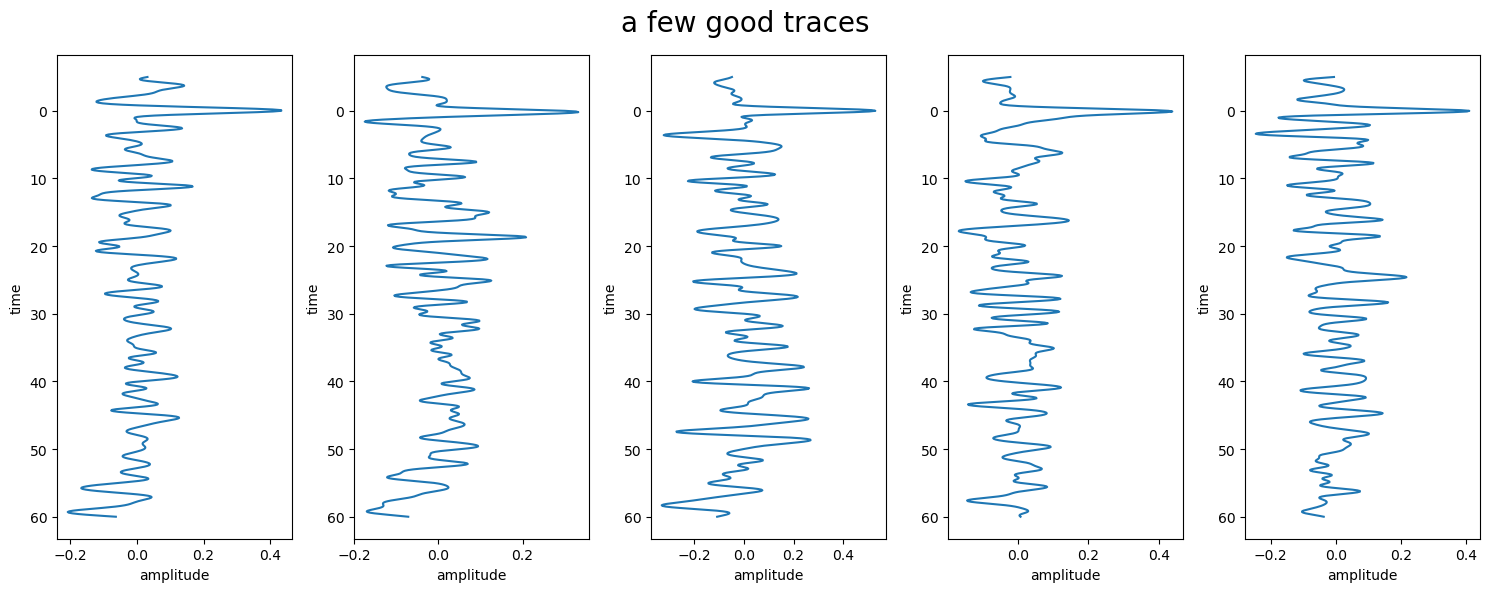

In [8]:
import matplotlib.pyplot as plt

goodtraceindex = np.nonzero(flag_data)[0].reshape(-1,1)

fig, axs = plt.subplots(1,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle('a few good traces', fontsize=20)

axs = axs.ravel()
ic = 0
for icount in goodtraceindex[5:10,0]:       
              
    axs[ic].plot(amp_data[icount,:], time[0])
    axs[ic].invert_yaxis()
    axs[ic].set_xlabel('amplitude')
    axs[ic].set_ylabel('time')
        
    ic = ic + 1
        
# tight_layout() will also adjust spacing between subplots to minimize the overlaps    
plt.tight_layout()      
plt.show()       

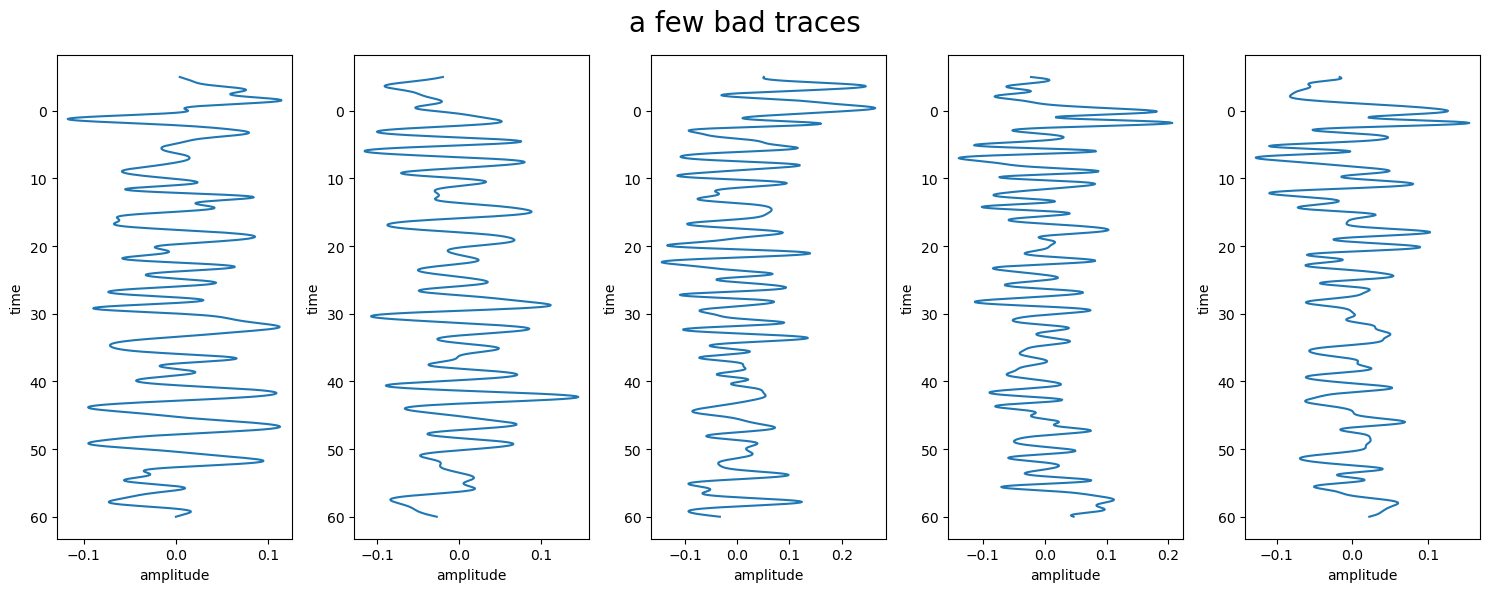

In [10]:
badtraceindex = np.where(flag_data == 0)[0].reshape(-1,1)

fig, axs = plt.subplots(1,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle('a few bad traces', fontsize=20)

axs = axs.ravel()
ic = 0
for icount in badtraceindex[10:15,0]:       
              
    axs[ic].plot(amp_data[icount,:], time[0])
    axs[ic].invert_yaxis()
    axs[ic].set_xlabel('amplitude')
    axs[ic].set_ylabel('time')
        
    ic = ic + 1
          
plt.tight_layout()      
plt.show()       

## 3. Create tranining, validation and test data sets

In [11]:
np.random.seed(42)
whole_data = np.append(amp_data,flag_data,1)

In [12]:
whole_data_permute = whole_data[np.random.permutation(whole_data.shape[0]),:] 

Create training data set using the  <font color=red>**first 9,000**</font> seismic traces and their corresponding labels in <font color=blue>**whole_data_permute**</font>. Name the training set as <font color=green>**X_train**</font> and <font color=green>**y_train**</font>.  <br>

In [13]:
X_train = whole_data_permute[0:9000,:-1]
y_train = whole_data_permute[0:9000,-1]


Create a validation data set using the  <font color=red>**next 1,000**</font> seismic traces and their corresponding labels in <font color=blue>**whole_data_permute**</font>. Name the validation set as <font color=green>**X_valid**</font> and <font color=green>**y_valid**</font>. <br>

In [14]:
X_valid = whole_data_permute[9000:10000,:-1]
y_valid = whole_data_permute[9000:10000,-1]


Create a test data set using <font color=red>**all the rest**</font> seismic traces and their corresponding labels in <font color=blue>**whole_data_permute**</font>. Name the test set as <font color=green>**X_test**</font> and <font color=green>**y_test**</font>.  <br>

In [15]:
X_test = whole_data_permute[10000:,:-1]
y_test = whole_data_permute[10000:,-1]


## 4. Create your own neural network

Create a neural network to classify the seismic traces into two categories. You can choose how many layers you want, and how many neurons in each layer, as long as the validation and test accuraries are greater than 88%. <br>

**Note**: Because we are dealing with a binary classifcation problem here, your output layer should have only one neuron and you should use sigmoid as the activation for the output layer. 

In [16]:
"""
Since this is binary classification the output activation layer needs to be 
sigmoidal with 1 neuron.
"""
model = keras.models.Sequential()
model.add(keras.layers.Dense(300,activation='relu',input_dim=651))
model.add(keras.layers.Dense(200,activation='relu'))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dense(50,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))

2022-11-15 13:56:20.385036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-15 13:56:20.385054: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-15 13:56:20.385067: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crumblerworm): /proc/driver/nvidia/version does not exist
2022-11-15 13:56:20.385236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Display the neural network.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               195600    
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 281,001
Trainable params: 281,001
Non-trainable params: 0
_________________________________________________________________


In [19]:
keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## 5. Compile the model

Compile the model. Remember to specify the loss function, the optimizer and the 'accuracy' metric. You can choose an optimizer that you like. <br>

**HINT:** Because we are dealing with binary classification, you can use `binary_crossentropy` as your loss. 

In [21]:
"""
I have seen the best results so far using the Adagrad optimizer, 
rather than SGD or others.
"""
model.compile(loss="binary_crossentropy",
              optimizer = keras.optimizers.Adagrad(learning_rate=0.01),
              metrics=["accuracy"])

## 6. Train the model

In [22]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid,y_valid))

Epoch 1/20
282/282 [==============================] - 1s 2ms/step - loss: 0.5364 - accuracy: 0.7624 - val_loss: 0.4791 - val_accuracy: 0.7600
Epoch 2/20
282/282 [==============================] - 0s 2ms/step - loss: 0.3741 - accuracy: 0.8113 - val_loss: 0.3045 - val_accuracy: 0.8720
Epoch 3/20
282/282 [==============================] - 0s 2ms/step - loss: 0.2717 - accuracy: 0.8800 - val_loss: 0.2652 - val_accuracy: 0.8870
Epoch 4/20
282/282 [==============================] - 0s 2ms/step - loss: 0.2391 - accuracy: 0.8956 - val_loss: 0.2879 - val_accuracy: 0.8720
Epoch 5/20
282/282 [==============================] - 0s 2ms/step - loss: 0.2231 - accuracy: 0.9046 - val_loss: 0.2515 - val_accuracy: 0.8870
Epoch 6/20
282/282 [==============================] - 0s 2ms/step - loss: 0.2069 - accuracy: 0.9116 - val_loss: 0.2456 - val_accuracy: 0.8910
Epoch 7/20
282/282 [==============================] - 0s 2ms/step - loss: 0.1939 - accuracy: 0.9199 - val_loss: 0.2438 - val_accuracy: 0.8950
Epoch 

## 7. Visualize the learning curves.

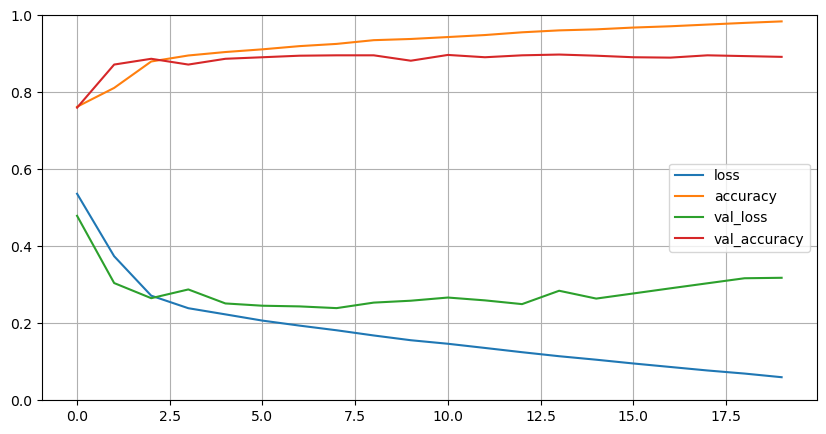

In [23]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(10,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## 8. Evaluate the model using test data

In [24]:
model.evaluate(X_test,y_test)

82/82 [==============================] - 0s 761us/step - loss: 0.2534 - accuracy: 0.9130


[0.253387451171875, 0.9129765033721924]

In [26]:
# Pick the first 5 instances in the X test array
X_new = X_test[:5]

# Make prediction using test dataset
y_prob = model.predict(X_new)  
print('Prediction of first five instances: ')
print(y_prob>0.5)

# # Or using the depreciated method
# y_proba = model.predict_classes(X_new)
# print('Prediction of first five instances:')
# print(y_proba)

# # Suppress depreciation warning
# import warnings
# warnings.filterwarnings("ignore",category=DeprecationWarning)

# Print true values
print('True values: ')
print(y_test[:5])

1/1 [==============================] - 0s 13ms/step
Prediction of first five instances: 
[[False]
 [False]
 [ True]
 [ True]
 [ True]]
True values: 
[0. 0. 1. 1. 1.]
